# Assignment 3 - Security and Privacy of Machine Learning
### By Daan Brugmans (s1080742)

This notebook contains the implementation of Assignment 3 for the Radboud University course [Security and Privacy of Machine Learning](https://www.ru.nl/courseguides/science/vm/osirislinks/imc/nwi-imc069/).
The topic at hand is to execute, analyze, and defend against poisoning attacks on convolutional neural networks within a *Federated Learning (FL)* setting.
Specifically, this notebook wil look at [BadNet Attacks](https://arxiv.org/abs/1708.06733) and [Blend Attacks](https://arxiv.org/pdf/1712.05526). 
A model will be trained using FL, and some of the participants will poison their local model during the FL process.
This notebook will look at a variety of consequences of poisoned models in an FL setup.

This notebook is divided into two parts.
In the first part, we will set up and define all components that we need in order to answer the questions posed in the assignment.
In the second part, we will answer the questions in a Q&A-style by providing the question, the code that will give us an answer, and the answer itself.

Additionally, there is a subdirectory called `src`.
This folder contains a set of Python files directly taken from the week 11 tutorial (Federated Learning, dr. Picek).
Many aspects of the FL setting are already implemented in these files and I will make use of them.

This notebook should show all results without being needed to run.
However, if you do want to run this notebook, I have provided a `requirements.txt` that you can use to install all the required packages.
You can also find this notebook with [this URL](https://github.com/daanbrugmans/ru-security-and-privacy-of-machine-learning-23-24/blob/main/assignments/assignment-3/assignment-3.ipynb).

## Part 1: Setup

### 1.1 Imports
We will use PyTorch as the main environment for our deep learning endeavors. To this end, we will use the `torch` and `torchvision` packages.

In [13]:
import src.Utils
import src.PoisoningUtils
import src.TrainingUtils
import src.ModelUtils
from src.ResNet18Light import ResNet18Light
from src.DataLoader import MyDataLoader
from src.ModelStateDictNames import NAMES_OF_AGGREGATED_PARAMETERS

import random
import gc
import statistics
from abc import ABC, abstractmethod
from copy import copy

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from PIL import Image
from tqdm import tqdm

import torch
import torch.nn.utils.prune 
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torch.utils.data import random_split

import torchvision
from torchvision import transforms

### 1.2 Preparation
Some preparatory code is performed here: we set a seed for `torch`, `numpy`, and `random` for reproducibility, and we set the device on which we will perform our model training. We also define a function for visualizing a batch of images, so that we can visually check if a backdoor has been executed successfully.

In [2]:
def visualize_batch(images: torch.Tensor, labels: torch.Tensor):
    """Visualizes a batch of images.
    
    Taken from week 9 notebook (Backdoor Defenses, dr. Picek) and refactored."""
    
    # Making sure we can view the images
    images = images.detach().numpy()
    images = images*255
    images = [image.astype(np.uint8) for image in images]
    images = [np.moveaxis(image, source=0, destination=-1) for image in images]
    
    # Plot the images in the batch, along with the corresponding labels
    fig = plt.figure(figsize=(25, 4))
    for idx in np.arange(20):
        ax = fig.add_subplot(2, 20//2, idx+1, xticks=[], yticks=[])
        ax.imshow(images[idx], cmap='viridis')
        # Print out the correct label for each image
        # .item() gets the value contained in a Tensor
        ax.set_title(str(labels[idx].item()))
    
    plt.show()

def set_global_seed(seed):
    """Sets the same seed for varying libraries.
    
    Taken from week 5 lab notebook (Evasion Attacks (Defenses), dr. Picek)"""
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)

        torch.backends.cudnn.benchmark = False
        torch.backends.cudnn.deterministic = True
        
set_global_seed(3131)
        
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

if str(device) == "cuda":
    print(torch.cuda.get_device_name())

cuda
NVIDIA GeForce GTX 1050


### 1.3 Attacks
Here, we define the attacks that we will perform on our neural network.
We define two backdoor attack models: the BadNet Attack and the Blend Attack.
I made the implementation for the Blend Attack myself, using template code from the week 8 tutorial.
The BadNet Attack uses the backdoor implemented in `src.PoisoningUtils.py`.

In [3]:
class BackdoorAttack(ABC):
    def __init__(self) -> None:
        self.attack_name: str
        self.source_label: int
        self.target_label: int
    
    @abstractmethod
    def execute(self, image: torch.Tensor):
        raise NotImplementedError("The Attack base class is abstract. Please use an implementation of an Attack.")
    
class BadNetAttack(BackdoorAttack):
    def __init__(self, source_label: int, target_label: int) -> None:
        super().__init__()
        
        self.attack_name = "BadNet Attack"
        
        self.source_label = source_label
        self.target_label = target_label
        
        # Precomputed for CIFAR-10, taken from week 11 tutorial on Federated Learning
        self.data_mean = torch.from_numpy(np.array([0.4914, 0.4822, 0.4465]))
        self.data_std = torch.from_numpy(np.array([0.2023, 0.1994, 0.2010]))
        
    def execute(self, image: torch.Tensor) -> torch.Tensor:
        backdoored_image, _ = src.PoisoningUtils.poison_single_image(
            image=image,
            label=self.target_label,
            BACKDOOR_TARGET_CLASS=self.target_label,
            MEAN=self.data_mean,
            STD_DEV=self.data_std
        )
        
        return backdoored_image

class BlendAttack(BackdoorAttack):
    def __init__(self, source_label: int, target_label: int) -> None:
        super().__init__()
        
        self.attack_name = "Blend Attack"
        
        self.source_label = source_label
        self.target_label = target_label
        
        self.blend_image = Image.open("./hello_kitty.jpg")
        self.blend_image = self.blend_image.resize((32, 32))
        self.blend_image = np.array(self.blend_image) / 255
        self.blend_image = np.moveaxis(self.blend_image, source=-1, destination=0)
        
    def execute(self, image: torch.Tensor) -> torch.Tensor:
        backdoored_image = image + self.blend_image
        backdoored_image = backdoored_image / 2
        backdoored_image = backdoored_image.to(torch.float32)
        
        return backdoored_image

### 1.4 Data
We load the CIFAR-10 dataset using the function `get_cifar10_dataloaders`. When called, the function returns 3 `DataLoader` objects: for the train set, the validation set, and the test set respectively.

In [4]:
def get_cifar10_dataloaders(train_split=0.8) -> tuple[DataLoader, DataLoader, DataLoader]:
    """Returns DataLoader objects for a train, validation, and test set of the CIFAR-10 dataset. If an `Attack` object is passed, it will backdoor the data using the object first."""
    
    cifar10_dataset_train_val = torchvision.datasets.CIFAR10(root="d:/Datasets", train=True, download=True, transform=FLSettings.transform_train)
    cifar10_dataset_test = torchvision.datasets.CIFAR10(root="d:/Datasets", train=False, download=True, transform=FLSettings.transform_test)

    train_size = int(len(cifar10_dataset_train_val) * train_split)
    val_size = int(len(cifar10_dataset_train_val) - train_size)
    cifar10_dataset_train, cifar10_dataset_val = random_split(cifar10_dataset_train_val, [train_size, val_size])
    
    cifar10_dataloader_train = DataLoader(cifar10_dataset_train, batch_size=128, shuffle=True)
    cifar10_dataloader_val = DataLoader(cifar10_dataset_val, batch_size=128, shuffle=False)
    cifar10_dataloader_test = DataLoader(cifar10_dataset_test, batch_size=128, shuffle=False)
    
    return cifar10_dataloader_train, cifar10_dataloader_val, cifar10_dataloader_test

### 1.5 Neural Network
The following code block consists of a class definition for the `NeuralModel`.
This class is a collection of all processes and objects that are needed for training a neural network.
It contains a pre-trained instance of the `ResNet18Light` network, as defined in `src/ResNet18Light.py`, as well as the network's loss function, its optimizer, the number of training epochs, and dataloaders for the train, validation, and test sets.

I have chosen to implement it this way, so that all code related to the neural network and its architecture is encapsulated within a single class.
In my opinion, this makes performing varying attacks very clean: with only a few rows of code, I am able to instantiate, train, and test a new model.
This makes the experiments easy to read and hides away set implementation details.

In [5]:
class NeuralModel:
    def __init__(self, network_name: str = "", epochs: int = 30) -> None:
        pretrained_weights_file = "./R0099.pt"
        self.neural_network_state_dict = torch.load(pretrained_weights_file, map_location=device)
        self.neural_network = ResNet18Light(network_name).to(device)
        self.neural_network.load_state_dict(self.neural_network_state_dict)
        
        self.loss_function = nn.CrossEntropyLoss()
        self.optimizer = torch.optim.AdamW(self.neural_network.parameters(), lr=0.001)
        self.epochs = epochs
        
        self.train_data, self.val_data, self.test_data = get_cifar10_dataloaders()

### 1.6 Metrics

We define the metrics with which we measure the effectiveness of our attacks and defenses. These are the Attack Succes Rate (ASR), which measures how many of our adversarial samples resulted in wrongful classification, and the Clean Accuracy Drop, which measures the decrease in accuracy on a clean dataset when a clean model is fed adversarial samples.

In [6]:
def _count_non_source_misclassifications(targets: torch.Tensor, predictions: torch.Tensor, source_label, target_label):
    """Calculates and returns the number of classifications of images with a label that is not the source label nor the target label.
    
    Taken from the week 9 lab notebook (Backdoor Defenses, dr. Picek) and refactored."""
    
    sub_non_source_total = 0
    sub_misclassifications = 0
    
    sub_non_source_total_dict = {}
    sub_misclassification_dict = {}

    # Find all the images with a different label than the source or target label
    indices = torch.logical_and((targets != source_label), (targets != target_label)).nonzero(as_tuple=False).numpy()
    indices = indices.reshape(indices.shape[0])
    sub_non_source_total += indices.shape[0]

    # For all non-source and non-target label images, check if the prediction is equal to the target label
    for index in indices:
        target = targets[index].detach().cpu().numpy()
        prediction = predictions[index].detach().cpu().numpy()
        
        if str(target) in sub_non_source_total_dict:
            sub_non_source_total_dict[str(target)] += 1
        else:
            sub_non_source_total_dict[str(target)] = 1
        
        if prediction == target_label:
            sub_misclassifications += 1
            
            if str(target) in sub_misclassification_dict:
                sub_misclassification_dict[str(target)] += 1
            else:
                sub_misclassification_dict[str(target)] = 1
    
    return sub_misclassifications, sub_non_source_total, sub_misclassification_dict, sub_non_source_total_dict

def _count_source_specific_classifications(targets: torch.Tensor, predictions: torch.Tensor, source_label: int, target_label: int):
    """Calculates and returns the number of classifications of images with the source label.
    
    Taken from the week 9 lab notebook (Backdoor Defenses, dr. Picek) and refactored."""
    sub_total = 0
    sub_correct = 0
    
    # Find all the images with the source label
    indices = (targets == source_label).nonzero(as_tuple=False).numpy()
    indices = indices.reshape(indices.shape[0])
    sub_total += indices.shape[0]
    
    # For all source label images, check if the prediction is equal to the target label
    for i in indices:
        if predictions[i].detach().cpu().numpy() == target_label:
            sub_correct += 1
    
    return sub_correct, sub_total

def attack_success_rate(model: NeuralModel, adversarial_test_data: src.PoisoningUtils.BackdoorData, target_label: int, source_label: int = None, verbose: bool = False) -> float:
    """Calculates and returns the Attack Success Rate.
    
    Taken from the week 9 lab notebook (Backdoor Defenses, dr. Picek) and refactored."""
    
    correct = 0
    total = 0
    non_source_total = 0
    misclassifications = 0
    
    non_source_total_dict = {}
    misclassification_dict = {}

    with torch.no_grad():
        model.neural_network.eval()

        for images, targets in tqdm(adversarial_test_data):
            # Use poisoned test image to get predictions of backdoored model
            images = images.to(device)
            outputs = model.neural_network(images).detach()
            _, predictions = torch.max(outputs, dim=1)
            
            # If source agnostic attack
            if source_label is None:
                # For all test samples, check if the predicted label is equal to the target label
                for i in range(len(images)):
                    if targets[i] != target_label:
                        total += 1
                        
                        if predictions[i].detach().cpu().item() == target_label:
                            correct += 1
            # If source specific attack
            else:
                sub_correct, sub_total = _count_source_specific_classifications(targets, predictions, source_label, target_label)
                correct += sub_correct
                total += sub_total
                
                if verbose:
                    sub_misclassifications, sub_non_source_total, sub_misclassification_dict, sub_non_source_total_dict = _count_non_source_misclassifications(targets, predictions, source_label, target_label)
                    misclassifications += sub_misclassifications
                    non_source_total += sub_non_source_total
                    
                    for key in sub_misclassification_dict.keys():
                        if key in misclassification_dict:
                            misclassification_dict[key] += sub_misclassification_dict[key]
                        else:
                            misclassification_dict[key] = sub_misclassification_dict[key]
                            
                    for key in sub_non_source_total_dict.keys():
                        if key in non_source_total_dict:
                            non_source_total_dict[key] += sub_non_source_total_dict[key]
                        else:
                            non_source_total_dict[key] = sub_non_source_total_dict[key]
                            
        if verbose:
            for key in non_source_total_dict.keys():
                if key in misclassification_dict:
                    misclassification_dict[key] = round(misclassification_dict[key] / non_source_total_dict[key], 2)
                else:
                    misclassification_dict[key] = 0

    attack_success_rate = correct / total
    print(f"Attack Success Rate: {round(attack_success_rate, 2)}")
    
    if source_label and verbose:
        print(f"Number of Misclassifications:", misclassifications)
        print(f"Number of Images Not With Source Label:", non_source_total)
        print("Rate of Misclassification for Backdoored Images with Labels other than Source of Target:")
        
        for key, value in misclassification_dict.items():
            print(f" {key}: {value}")
        
        misclassification_rate = misclassifications / non_source_total
        print(f"False Positive Rate: {round(misclassification_rate, 2)}")
        
    return attack_success_rate

### 1.7 Aggregation Methods
We define a set of aggregation methods to aggregate the local models.
These include the [FedAvg](https://arxiv.org/pdf/1602.05629) and [Krum](https://proceedings.neurips.cc/paper_files/paper/2017/file/f4b9ec30ad9f68f89b29639786cb62ef-Paper.pdf) aggregation algorithms.
The FedAvg algorithm is taken from the week 11 tutorial on Federated Learning.
I implemented the Krum algorithm myself.
However, this implementation is a bit *krummy*, and only works when $k = 2$.
This should suffice for the assignment, but it cannot be generalized to other values of $k$.

In [7]:
def fed_avg(all_models, base_model, verbose=True):
    """
    Perform FedAvg algorithm
    :param all_models list of state dicts, containing the locally trained parameters of the individual clients
    :param base_model state dict of arbitrary model, useful for knowing the names of all parameters and copying values of not 
    aggregated parameters
    :return state dict of aggregated model (obtained by FedAvg)
    
    Taken from the week 11 lab notebook (Federated Learning, dr. Picek) and refactored.
    """
    
    if verbose:
        src.Utils.print_timed(f'Aggregate {len(all_models)} models')
   
    result_state_dict = {name: torch.zeros_like(data) for name, data in base_model.items()} 
    n_models = len(all_models) 
    
    for state_dict in all_models:
        for layer_name in state_dict.keys():
            if layer_name in NAMES_OF_AGGREGATED_PARAMETERS:
                result_state_dict[layer_name] += state_dict[layer_name].to(device)
            else:
                result_state_dict[layer_name] += base_model[layer_name]
                
    for layer_name in result_state_dict.keys():
        result_state_dict[layer_name] = result_state_dict[layer_name] / n_models
    
    return result_state_dict


def krum(all_models, base_model, malignant_client_count, verbose=True):
    if verbose:
        src.Utils.print_timed(f'Aggregate {len(all_models)} models')
   
    result_state_dict = {name: torch.zeros_like(data) for name, data in base_model.items()} 
    n_models = len(all_models) 
    
    for layer_name in base_model:
        if layer_name not in NAMES_OF_AGGREGATED_PARAMETERS:
            result_state_dict[layer_name] = base_model[layer_name]
        else:           
            k = n_models - malignant_client_count - 2 
            # Check if k == 2, otherwise Krum breaks, I can't make it work otherwise
            if k != 2:
                raise ValueError("k = n - f - 2 should be 2, otherwise the implementation does not work. It is now", k)
            
            top1_smallest_l2_sum = float("inf")
            top2_smallest_l2_sum = float("inf")
            
            index_top1_smallest_l2_sum = float("inf")
            index_top2_smallest_l2_sum = float("inf")
            
            for current_client_index, current_state_dict in enumerate(all_models):
                top1_distance = float("inf")
                top2_distance = float("inf")
                
                for other_client_index, other_state_dict in enumerate(all_models):
                    if current_client_index == other_client_index:
                        continue
                    
                    euclidean_distance = F.pairwise_distance(
                        x1=current_state_dict[layer_name],
                        x2=other_state_dict[layer_name],
                        p=2
                    )
                    
                    euclidean_distance = torch.sum(euclidean_distance)
                    
                    if euclidean_distance < top1_distance:
                        top2_distance = top1_distance
                        top1_distance = euclidean_distance
                    elif euclidean_distance < top2_distance:
                        top2_distance = euclidean_distance
                    
                local_model_score = top1_distance + top2_distance
                
                if local_model_score < top1_smallest_l2_sum:
                    top2_smallest_l2_sum = top1_smallest_l2_sum
                    top1_smallest_l2_sum = local_model_score
                    
                    index_top2_smallest_l2_sum = index_top1_smallest_l2_sum
                    index_top1_smallest_l2_sum = current_client_index
                elif local_model_score < top2_smallest_l2_sum:
                    top2_smallest_l2_sum = local_model_score
                    
                    index_top2_smallest_l2_sum = current_client_index
                    
            result_state_dict[layer_name] += all_models[index_top1_smallest_l2_sum][layer_name].to(device)
            result_state_dict[layer_name] += all_models[index_top2_smallest_l2_sum][layer_name].to(device)
            
            result_state_dict[layer_name] = result_state_dict[layer_name] / k
    
    return result_state_dict

### 1.8 Federated Learning
#### 1.8.1 Settings
We define some settings related to Federated Learning.
These settings can be tweaked during the assignment and make sure that the already implemented FL code in `src` works correctly.
The settings are thusly taken from the week 11 tutorial (Federated Learning, dr. Picek).

In [8]:
class FLSettings:
    total_client_count = 6
    malignant_client_count = 2
    benign_client_count = total_client_count - malignant_client_count
    
    iid_rate = 0.9
    samples_per_client = 384
    batch_size = 64
    test_batch_size = 1024
        
    global_aggregation_rounds = 5
    local_epochs = 2
    client_count_per_round = 5
    aggregation_function_name = "FedAvg"
    
    malignant_client_poisoning_rate = 0.5
    backdoor_target_class = 0
    backdoor_attack = BlendAttack(source_label=None, target_label=backdoor_target_class)
    scale_attack = False
    clip_defense = False
    
    data_mean = torch.from_numpy(np.array([0.4914, 0.4822, 0.4465]))
    data_std = torch.from_numpy(np.array([0.2023, 0.1994, 0.2010]))
    
    transform_train = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(data_mean, data_std),
    ])
    
    transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(data_mean, data_std),
    ])

#### 1.8.2 Setup
We initiate an FL setup using code from `src` and the week 11 tutorial about Federated Learning.
We compute the indices of the data samples that we give to each client, so that every client has a local dataset to train on, and we setup both clean and backdoored test datasets.

In [9]:
cifar10_train = torchvision.datasets.CIFAR10(root="d:/Datasets", download=True, train=True, transform=FLSettings.transform_train)
cifar10_test = [p for p in torchvision.datasets.CIFAR10(root="d:/Datasets", download=True, train=False, transform=FLSettings.transform_test)]

train_data_by_labels, all_labels, all_training_images = src.Utils.sort_samples_by_labels(cifar10_train)

client_data_indices, main_labels_dict = src.Utils.create_client_distributions(
    total_client_number=FLSettings.total_client_count,
    iid_rate=FLSettings.iid_rate,
    samples_per_client=FLSettings.samples_per_client,
    all_labels=all_labels,
    train_data_by_labels=train_data_by_labels,
    all_training_images=all_training_images
)

all_training_data = [MyDataLoader(cifar10_train, indices, FLSettings.batch_size) for indices in tqdm(client_data_indices)]

test_data = src.Utils.batchify(cifar10_test, FLSettings.test_batch_size, len(cifar10_test))
test_data = [(x.to(device), y.to(device)) for x, y in test_data]

all_test_samples = []
for image, label in cifar10_test:
    if label == FLSettings.backdoor_target_class:
        continue
    
    all_test_samples.append((image, label))
    
backdoor_test_data_loader = DataLoader(all_test_samples, batch_size=FLSettings.test_batch_size, shuffle=True)
backdoor_test_data = src.PoisoningUtils.BackdoorData(
        data_loader=backdoor_test_data_loader,
        attack=FLSettings.backdoor_attack,
        pdr=1.0,
        is_test_dataloader=True,
        BACKDOOR_TARGET_CLASS=FLSettings.backdoor_target_class,
        MEAN=FLSettings.data_mean,
        STD_DEV=FLSettings.data_std,
        COMPUTATION_DEVICE=device
    )
backdoor_test_data.cuda()


Files already downloaded and verified
Files already downloaded and verified


50000it [00:25, 1983.70it/s]


2024-05-30 11:10:22.157826: Samples from main class per client: 38
2024-05-30 11:10:22.158809: Samples from all classes per client: 346
2024-05-30 11:10:22.168807: Main label for clients: {0: 6, 1: 3, 2: 1, 3: 8, 4: 6, 5: 7} 


100%|██████████| 6/6 [00:01<00:00,  3.98it/s]


#### 1.8.3 Scaling Attack & Clipping Defense
We also define implementations for a Model Scaling Attack and the Clipping Defense.
The implementation for the Scaling Attack comes from the week 11 tutorial and is a function called `scale_update`.

In [34]:
def scale_update(model_state_dict, global_model_state_dict):
    """
    Scales all parameters of a model update U, for a given model m=U+g, where g is the global model
    (here the global_model_state_dict_on_cpu)
    :param model_state_dict state dict of the local model m, where the update shall be scaled
    :param scaling_factor scalar, indicating how much the update shall be scaled
    :return state dict, containing the new model, where the update, therefore, the difference between model and the 
    global model was scaled by the given scaling factor and all parameters not in NAMES_OF_AGGREGATED_PARAMETERS remain 
    unchanged
    
    Taken from the week 11 tutorial on Federated Learning (dr. Picek) and refactored."""
    global_model_state_dict_on_cpu = {name: param.detach().cpu() for name, param in global_model_state_dict.items()}    
    scaled_model_state_dict = {}
    
    for layer_name in model_state_dict.keys(): 
      if layer_name in NAMES_OF_AGGREGATED_PARAMETERS:
        scaling_factor = FLSettings.client_count_per_round / FLSettings.malignant_client_count
        scaled_model_state_dict[layer_name] = scaling_factor * (model_state_dict[layer_name] - global_model_state_dict_on_cpu[layer_name]) + global_model_state_dict_on_cpu[layer_name]
        egg = ""
      else:
        scaled_model_state_dict[layer_name] = global_model_state_dict_on_cpu[layer_name]

    return scaled_model_state_dict
  
  
def clip_local_models(global_model_state_dict, local_models_state_dicts):
    global_model_state_dict_on_cpu = {name: param.detach().cpu() for name, param in global_model_state_dict.items()}  
    
    for layer_name in global_model_state_dict_on_cpu.keys():
        local_model_l2s = {}
        
        if layer_name in NAMES_OF_AGGREGATED_PARAMETERS:
            for client_index, local_model in enumerate(local_models_state_dicts):
                local_model_l2s[client_index] = src.ModelUtils.model_dist_norm(
                    model1=global_model_state_dict_on_cpu,
                    model2=local_model,
                    NAMES_OF_AGGREGATED_PARAMETERS=NAMES_OF_AGGREGATED_PARAMETERS
                )
          
            median_l2 = torch.median(torch.stack(list(local_model_l2s.values())))
        
            for client_index, local_model in enumerate(local_models_state_dicts):
                local_models_state_dicts[client_index][layer_name] = torch.clip(input=local_models_state_dicts[client_index][layer_name], max=median_l2)
    
    return local_models_state_dicts

#### 1.8.4 Training Procedure
We define a single function that performs an entire federated learning scenario, `learn_federated`.
This is so that we can easily perform an entire federated learning scenario with slightly altered hyperparameters, such as the number of malignant clients.

In [18]:
def learn_federated() -> tuple[float, float]:
    global_model = NeuralModel("GlobalModel")
    local_training_data = []
    
    for client_data in all_training_data:
        local_training_data.append(copy(client_data))
    
    malignant_client_indexes = np.random.choice(a=FLSettings.total_client_count, size=FLSettings.malignant_client_count, replace=False).tolist()
    print("Indexes of Malignant Clients:", malignant_client_indexes)

    for client_index in malignant_client_indexes:
        local_training_data[client_index] = src.PoisoningUtils.BackdoorData(
            data_loader=local_training_data[client_index],
            attack=FLSettings.backdoor_attack,
            pdr=FLSettings.malignant_client_poisoning_rate,
            BACKDOOR_TARGET_CLASS=FLSettings.backdoor_target_class,
            MEAN=FLSettings.data_mean,
            STD_DEV=FLSettings.data_std,
            COMPUTATION_DEVICE=device
        )
    
    local_models = []
    for client_index in range(FLSettings.total_client_count):
        local_models.append(NeuralModel(f"LocalModel{client_index}"))

    for _ in range(FLSettings.global_aggregation_rounds):
        all_trained_weights = []
        
        excluded_client_index = np.random.randint(low=0, high=FLSettings.total_client_count, size=1)
        print("Excluded client this round:", excluded_client_index)
        
        for client_index in range(FLSettings.total_client_count):        
            if client_index == excluded_client_index:
                continue
                    
            src.Utils.print_timed(f'Client {client_index}')
            
            trained_weights = src.TrainingUtils.client_training(
                global_model_state_dict=global_model.neural_network_state_dict,
                local_model=local_models[client_index].neural_network,
                local_training_data=local_training_data[client_index],
                local_epochs=FLSettings.local_epochs,
                printing_prefix='\t',
                COMPUTATION_DEVICE=device
            )
            
            if (FLSettings.scale_attack) and (client_index in malignant_client_indexes):
                trained_weights = scale_update(model_state_dict=trained_weights, global_model_state_dict=global_model.neural_network_state_dict)
            
            all_trained_weights.append(trained_weights)
            
        if FLSettings.clip_defense:
            all_trained_weights = clip_local_models(global_model_state_dict=global_model.neural_network_state_dict, local_models_state_dicts=all_trained_weights)
        
        hash_values = src.ModelUtils.get_models_hash(all_trained_weights)
        
        if FLSettings.aggregation_function_name == "FedAvg":
            aggregated_weights = fed_avg(all_trained_weights, global_model.neural_network_state_dict)
        elif FLSettings.aggregation_function_name == "Krum":
            aggregated_weights = krum(all_trained_weights, global_model.neural_network_state_dict, FLSettings.malignant_client_count)
        else:
            ValueError(f"Invalid aggregation function was chosen in FLSettings: {FLSettings.aggregation_function_name}")
        
        src.ModelUtils.check_hashs(all_trained_weights, hash_values)
        
        global_model.neural_network.load_state_dict(aggregated_weights)
        global_model.neural_network_state_dict = aggregated_weights
        _ = src.ModelUtils.test(test_data, global_model.neural_network)

    accuracy, _ = src.ModelUtils.evaluate_model(
        model_to_evaluate=global_model.neural_network,
        test_data=test_data,
        backdoor_test_data=backdoor_test_data
    )
    
    return accuracy / 100, attack_success_rate(
        model=global_model,
        adversarial_test_data=backdoor_test_data,
        target_label=FLSettings.backdoor_target_class,
        source_label=None,
        verbose=False
    )

## Part 2: Q&A

### 2.1 Backdoor Attack in Federated Learning

#### 2.1.a 
Q: Implement a source-agnostic backdoor attack in FL using the
Blend attack with the Hello Kitty image. Below you find a list of parameters/settings to use for this attack. Limit your implementation to these values.
You will be investigating the performance of the attack with different number of
malicious clients in the network, i.e., 1, 2, or 3. In all cases, a total of 6 clients
compose the network. For example, in the first setting you have 1 malicious
and 5 benign clients. However, we ask you to select only a subset from all the
clients each round to perform the local training. This subset selection should be
random, but you are free how you implement this selection procedure. In the
end of the training, i.e., after 5 rounds of FL, plot the final ASR (y-axis) and
the global (poisoned) model’s task accuracy (also y-axis) versus the number of
malicious clients (x-axis). Either make two plots, one for ASR and one for accuracy, or combine the results in one. The following parameters/settings should
be used:
- **Model**: Load the pre-trained ResNet18Light model from the Federated
Learning tutorial.
- **Poisoning Rate**: Every malicious client should use a poisoning rate of
50% of the local dataset.
- **Global Aggregation Rounds**: 5.
- **Local Training Epochs**: 2.
- **Backdoor Target Class**: 0 (airplane).
- **Number Selected Clients Per Round**: 5.
- **Aggregation Method**: FedAvg.

In [37]:
fl_metrics_df = pd.DataFrame(columns=["Malignant Client Count", "Score", "Metric"])

gc.collect()

6

In [38]:
FLSettings.malignant_client_count = 1
FLSettings.aggregation_function_name = "FedAvg"
FLSettings.scale_attack = False
FLSettings.clip_defense = False

accuracy, asr = learn_federated()

fl_metrics_df = pd.concat([fl_metrics_df, pd.DataFrame.from_dict({
    "Malignant Client Count": [FLSettings.malignant_client_count],
    "Score": [accuracy],
    "Metric": ["(Main Task) Accuracy"]
})])

fl_metrics_df = pd.concat([fl_metrics_df, pd.DataFrame.from_dict({
    "Malignant Client Count": [FLSettings.malignant_client_count],
    "Score": [asr],
    "Metric": ["Attack Success Rate (ASR)"]
})])

Files already downloaded and verified
Files already downloaded and verified
Indexes of Malignant Clients: [1]
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Excluded client this round: [1]
2024-05-29 16:38:16.341501: Client 0
2024-05-29 16:38:17.062846: 	local_epoch   0 | lr 0.2 | ms/batch 715.35| loss  3.91
2024-05-29 16:38:17.611714: 	local_epoch   1 | lr 0.2 | ms/batch 548.87| loss  1.07
2024-05-29 16:38:17.626712: Client 2
2024-05-29 16:38:18.189695: 	local_epoch   0 | lr 0.2 | ms/batch 552.98| loss  3.33
2024-05-29 16:38:18.743678: 	local_epoch   1 | lr 0.2 | ms/batch 553.98| los

100%|██████████| 9/9 [00:05<00:00,  1.74it/s]

Attack Success Rate: 0.92



C:\Users\Daan\AppData\Local\Temp\ipykernel_21552\4107697643.py:4: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  fl_metrics_df = pd.concat([fl_metrics_df, pd.DataFrame.from_dict({


In [39]:
FLSettings.malignant_client_count = 2
FLSettings.aggregation_function_name = "FedAvg"
FLSettings.scale_attack = False
FLSettings.clip_defense = False

accuracy, asr = learn_federated()

fl_metrics_df = pd.concat([fl_metrics_df, pd.DataFrame.from_dict({
    "Malignant Client Count": [FLSettings.malignant_client_count],
    "Score": [accuracy],
    "Metric": ["(Main Task) Accuracy"]
})])

fl_metrics_df = pd.concat([fl_metrics_df, pd.DataFrame.from_dict({
    "Malignant Client Count": [FLSettings.malignant_client_count],
    "Score": [asr],
    "Metric": ["Attack Success Rate (ASR)"]
})])

Files already downloaded and verified
Files already downloaded and verified
Indexes of Malignant Clients: [5, 3]
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Excluded client this round: [0]
2024-05-29 16:39:49.511756: Client 1
2024-05-29 16:39:50.272769: 	local_epoch   0 | lr 0.2 | ms/batch 751.01| loss  3.31
2024-05-29 16:39:50.815752: 	local_epoch   1 | lr 0.2 | ms/batch 542.02| loss  0.75
2024-05-29 16:39:50.834715: Client 2
2024-05-29 16:39:51.383696: 	local_epoch   0 | lr 0.2 | ms/batch 541.95| loss  3.33
2024-05-29 16:39:51.925719: 	local_epoch   1 | lr 0.2 | ms/batch 542.02| 

100%|██████████| 9/9 [00:05<00:00,  1.74it/s]

Attack Success Rate: 0.99


In [40]:
FLSettings.malignant_client_count = 3
FLSettings.aggregation_function_name = "FedAvg"
FLSettings.scale_attack = False
FLSettings.clip_defense = False

accuracy, asr = learn_federated()

fl_metrics_df = pd.concat([fl_metrics_df, pd.DataFrame.from_dict({
    "Malignant Client Count": [FLSettings.malignant_client_count],
    "Score": [accuracy],
    "Metric": ["(Main Task) Accuracy"]
})])

fl_metrics_df = pd.concat([fl_metrics_df, pd.DataFrame.from_dict({
    "Malignant Client Count": [FLSettings.malignant_client_count],
    "Score": [asr],
    "Metric": ["Attack Success Rate (ASR)"]
})])

Files already downloaded and verified
Files already downloaded and verified
Indexes of Malignant Clients: [5, 1, 0]
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Excluded client this round: [0]
2024-05-29 16:41:21.805775: Client 1
2024-05-29 16:41:22.641746: 	local_epoch   0 | lr 0.2 | ms/batch 826.97| loss  9.38
2024-05-29 16:41:23.182937: 	local_epoch   1 | lr 0.2 | ms/batch 541.19| loss  3.04
2024-05-29 16:41:23.203453: Client 2
2024-05-29 16:41:23.754462: 	local_epoch   0 | lr 0.2 | ms/batch 546.01| loss  3.33
2024-05-29 16:41:24.297411: 	local_epoch   1 | lr 0.2 | ms/batch 542.9

100%|██████████| 9/9 [00:05<00:00,  1.67it/s]

Attack Success Rate: 0.99


,Malignant Client Count,Score,Metric
0,1,0.785100,(Main Task) Accuracy
0,1,0.923000,Attack Success Rate (ASR)
0,2,0.764200,(Main Task) Accuracy
0,2,0.992111,Attack Success Rate (ASR)
0,3,0.759100,(Main Task) Accuracy
0,3,0.991333,Attack Success Rate (ASR)


179

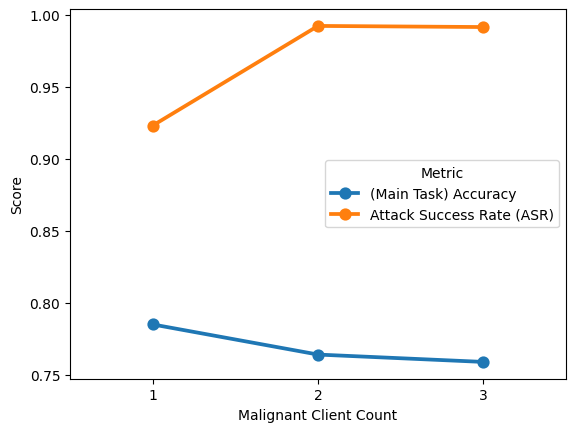

In [42]:
sns.pointplot(data=fl_metrics_df, x="Malignant Client Count", y="Score", hue="Metric")

display(fl_metrics_df)

gc.collect()

#### 2.1.b 
Q: In question 2.1.a we asked you to use a subset of clients each round.
What do you think is the influence of the number of selected clients on the
performance of the backdoor attack in the federated setting? Share your conclusions.

A: I think that the influence of the number of selected clients on the performance of the backdoor attack will vary significantly depending on what we assume that the share of malignant clients will be.
If the share of malignant clients is small, then I expect the procedure to be a mildly useful defense, as the global model has an opportunity to recuperate from learning the backdoor every once in a while when a malignant user is excluded.
However, if the share of malignant clients is bigger, or even approaching a 50/50 split between benign and malignant clients, then I think that the procedure may only make the backdoor worse, since there is a real chance that there will be round where the global model aggregates from mostly or exclusively malignant clients.
This dynamic holds true for when the number of selected clients changes: the smaller the number of selected clients is, the more likely it is that the model aggregates from mostly malignant clients for some rounds, and the more likely it is that the backdoor will be inserted.

#### 2.1.c
Q: In question 2.1.a we asked you to perform Federated Learning using
the FedAvg method for aggregation. Now using the same settings, but with just
1 malicious client, perform federated learning by making use of the **Krum** aggregation method. Plot the final ASR (y-axis) and global (poisoned) model task
accuracy (y-axis) for both the FedAvg and Krum methods (x-axis). Compare
the methods and share your conclusions on how both methods affect the ASR
and accuracy. For this homework question we ask you to assume 1 malicious
client, so f = 1. Also, only consider the subset of local models each round for
aggregation

# DO NOT RERUN!!!!!!!!!!!!!!!

In [107]:
fl_metrics_df = pd.DataFrame(columns=["Aggregation Method", "Score", "Metric"])

gc.collect()

54493

# DO NOT RERUN!!!!!!!!!!!!!!!

In [108]:
FLSettings.malignant_client_count = 1
FLSettings.aggregation_function_name = "FedAvg"
FLSettings.scale_attack = False
FLSettings.clip_defense = False

accuracy, asr = learn_federated()

fl_metrics_df = pd.concat([fl_metrics_df, pd.DataFrame.from_dict({
    "Aggregation Method": [FLSettings.aggregation_function_name],
    "Score": [accuracy],
    "Metric": ["(Main Task) Accuracy"]
})])

fl_metrics_df = pd.concat([fl_metrics_df, pd.DataFrame.from_dict({
    "Aggregation Method": [FLSettings.aggregation_function_name],
    "Score": [asr],
    "Metric": ["Attack Success Rate (ASR)"]
})])

Files already downloaded and verified
Files already downloaded and verified
Indexes of Malignant Clients: [1]
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Excluded client this round: [4]
2024-05-29 21:21:01.594114: Client 0
2024-05-29 21:21:02.597156: 	local_epoch   0 | lr 0.2 | ms/batch 994.04| loss  4.18
2024-05-29 21:21:03.477117: 	local_epoch   1 | lr 0.2 | ms/batch 878.99| loss  1.19
2024-05-29 21:21:03.491118: Client 1
2024-05-29 21:21:04.570115: 	local_epoch   0 | lr 0.2 | ms/batch 1070.97| loss  9.40
2024-05-29 21:21:05.847117: 	local_epoch   1 | lr 0.2 | ms/batch 1277.00| l

100%|██████████| 9/9 [00:17<00:00,  1.96s/it]

Attack Success Rate: 0.93



C:\Users\Daan\AppData\Local\Temp\ipykernel_21552\1976752154.py:6: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  fl_metrics_df = pd.concat([fl_metrics_df, pd.DataFrame.from_dict({


# DO NOT RERUN!!!!!!!!!!!!!!!

In [109]:
FLSettings.malignant_client_count = 1
FLSettings.aggregation_function_name = "Krum"
FLSettings.scale_attack = False
FLSettings.clip_defense = False

accuracy, asr = learn_federated()

fl_metrics_df = pd.concat([fl_metrics_df, pd.DataFrame.from_dict({
    "Aggregation Method": [FLSettings.aggregation_function_name],
    "Score": [accuracy],
    "Metric": ["(Main Task) Accuracy"]
})])

fl_metrics_df = pd.concat([fl_metrics_df, pd.DataFrame.from_dict({
    "Aggregation Method": [FLSettings.aggregation_function_name],
    "Score": [asr],
    "Metric": ["Attack Success Rate (ASR)"]
})])

Files already downloaded and verified
Files already downloaded and verified
Indexes of Malignant Clients: [1]
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Excluded client this round: [1]
2024-05-29 21:26:09.917404: Client 0
2024-05-29 21:26:11.245927: 	local_epoch   0 | lr 0.2 | ms/batch 1313.52| loss  4.18
2024-05-29 21:26:12.396927: 	local_epoch   1 | lr 0.2 | ms/batch 1151.00| loss  1.19
2024-05-29 21:26:12.419930: Client 2
2024-05-29 21:26:13.474936: 	local_epoch   0 | lr 0.2 | ms/batch 1046.01| loss  4.36
2024-05-29 21:26:14.497964: 	local_epoch   1 | lr 0.2 | ms/batch 1022.02|

100%|██████████| 9/9 [00:17<00:00,  1.95s/it]

Attack Success Rate: 0.01


# DO NOT RERUN!!!!!!!!!!!!!!!

,Aggregation Method,Score,Metric
0,FedAvg,0.788400,(Main Task) Accuracy
0,FedAvg,0.934333,Attack Success Rate (ASR)
0,Krum,0.796900,(Main Task) Accuracy
0,Krum,0.012222,Attack Success Rate (ASR)


169

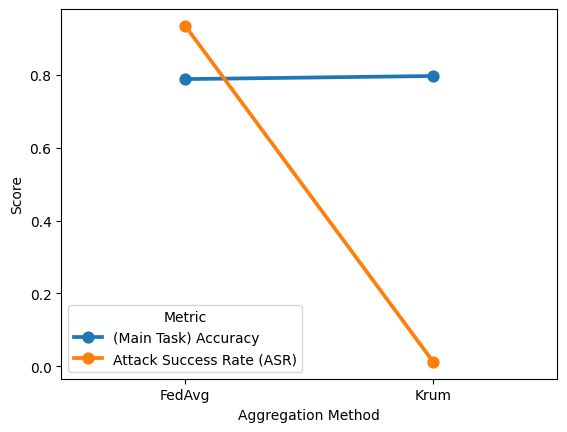

In [110]:
sns.pointplot(data=fl_metrics_df, x="Aggregation Method", y="Score", hue="Metric")

display(fl_metrics_df)

gc.collect()

A: When Krum aggregates the weights, it chooses only a subset of the local models to update the global model.
It chooses this subset by calculating the Euclidean distances between the models's weights.
Benign models will be close to each other in the Euclidean weight space, since they were trained on similar, unaltered data.
Malignant models will be further removed from other models, since they were trained on data that was altered.
Having learned from altered data, the weights of the malignant models will look more different from each other and from the benign models than the weights from benign models will look from other benign models.
By comparing these weights using the Euclidean distance, we find the models whose weights are most similar to one another, since they were trained on the similar data, and Krum then picks these models to aggregate local weights from.
This way, Krum excludes local models which are further removed from other models in the Euclidean space, which are likely to be malignant/backdoored.

In the figure, we can see that the accuracy for the global models is roughly the same when using either FedAvg or Krum.
However, while FedAvg results in a model with an ASR of over 90%, the ASR drops to near-zero when Krum is used as an aggregation method.
This is because of the reason explained above: Krum excludes the malignant model from the aggregation process by recognizing that it is far removed from the benign models in a Euclidean space.
The malignant model's exclusion from the aggregation prevents the insertion of the backdoor, which is why the ASR is so low when using Krum.
FedAvg does not have a check for potentially malignant models, so they are always included in the aggregation, meaning that the backdoor will be learned by the model with every aggregation round.

### 2.2 Distributed Backdoor Attack

#### 2.2.a
Q: Implement the Distributed Backdoor Attack (DBA). The network
of clients is composed of three malicious clients and three benign clients. The
three malicious clients will split a red 6 × 6 square trigger vertically into three
equal parts. Use the following parameters/settings for your attack:
- **Model**: Load the pre-trained ResNet18Light model from the Federated Learning tutorial.
- **Poisoning Rate**: Every malicious client should use a poisoning rate of 50% of the local dataset.
- **Global Aggregation Rounds**: 5.
- **Local Training Epochs**: 2.
- **Backdoor Target Class**: 0 (airplane).
- **Number Selected Clients Per Round**: 6 (all).
- **Aggregation Method**: FedAvg.

Plot the final ASR (y-axis) and global (poisoned) model task accuracy (y-axis).
Compare your results with your plot from question 1(a). How does DBA perform
compared to the previous FL attack setting? Which FL attack setup performs
best and why do you think this is the case? Share your conclusions.

*Note*: In DBA, during the training phase, the trigger pattern is split between
the clients, but in testing time, you should test the attack (i.e., ASR and Model
Accuracy) with the complete original trigger and not tear it apart! Once FL
training is finished, we assume just one global model in test time and no clients
and servers.

A: 

### 2.3 Clipping Defense

In [37]:
fl_scaling_df = pd.DataFrame(columns=["Scaling Approach", "Score", "Metric"])

gc.collect()

0

#### 2.3.a
Q: Take exactly the same settings as question 2.1.a but limit it to just 1
malicious client. Use the blend attack and at each round let the malicious client
apply the scale update with a scaling factor of $\gamma = \frac{n}{\mu}$. Here $n$ is the number of
clients and $\mu$ is the learning rate which is also the number of malicious clients
and thus now set to 1. Finally, plot the ASR (y-axis) and global model accuracy
(y-axis) for just the “scaling approach” (x-axis). Store these results, as you will
re-use them in a new plot for the next question.

In [38]:
FLSettings.malignant_client_count = 1
FLSettings.aggregation_function_name = "FedAvg"
FLSettings.scale_attack = True
FLSettings.clip_defense = False

accuracy, asr = learn_federated()

fl_scaling_df = pd.concat([fl_scaling_df, pd.DataFrame.from_dict({
    "Scaling Approach": ["Scaling"],
    "Score": [accuracy],
    "Metric": ["(Main Task) Accuracy"]
})])

fl_scaling_df = pd.concat([fl_scaling_df, pd.DataFrame.from_dict({
    "Scaling Approach": ["Scaling"],
    "Score": [asr],
    "Metric": ["Attack Success Rate (ASR)"]
})])

Files already downloaded and verified
Files already downloaded and verified
Indexes of Malignant Clients: [5]
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Excluded client this round: [0]
2024-05-30 12:05:12.575731: Client 1
2024-05-30 12:05:13.230726: 	local_epoch   0 | lr 0.2 | ms/batch 635.00| loss  3.42
2024-05-30 12:05:13.830760: 	local_epoch   1 | lr 0.2 | ms/batch 599.03| loss  1.03
2024-05-30 12:05:13.851730: Client 2
2024-05-30 12:05:14.462732: 	local_epoch   0 | lr 0.2 | ms/batch 599.97| loss  4.12
2024-05-30 12:05:15.061265: 	local_epoch   1 | lr 0.2 | ms/batch 598.53| los

100%|██████████| 9/9 [00:09<00:00,  1.03s/it]

Attack Success Rate: 1.0



C:\Users\Daan\AppData\Local\Temp\ipykernel_7956\603045659.py:8: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  fl_scaling_df = pd.concat([fl_scaling_df, pd.DataFrame.from_dict({


,Scaling Approach,Score,Metric
0,Scaling,0.159100,(Main Task) Accuracy
0,Scaling,0.995778,Attack Success Rate (ASR)


184

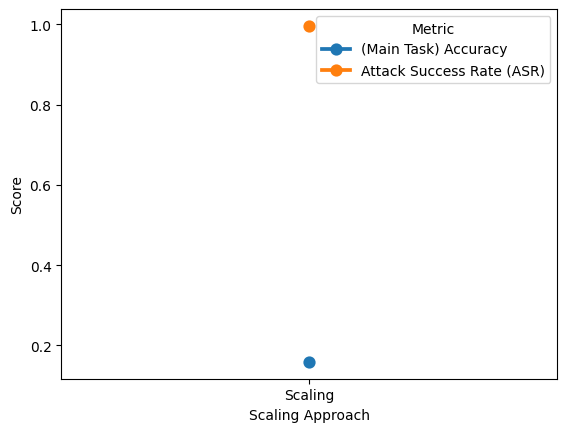

In [39]:
sns.pointplot(data=fl_scaling_df, x="Scaling Approach", y="Score", hue="Metric")

display(fl_scaling_df)

gc.collect()

#### 2.3.b
Q: Enforce an upper boundary for the L2-norms of model updates, restricting the Euclidean distances between the global and the respective local
models. The model shall be down-scaled if the L2-norm exceeds the boundary
(clipping).

A challenge here is determining a suitable clipping boundary: if it is fixed and too
low, the aggregated model will be very similar to the global model. Otherwise,
if too high, this does not prevent scaling-based attacks.
Since the norm values of the models change during the training process and
become smaller when the model converges, we need to select the boundary dynamically. For that, compute the Euclidean distance from every model to the
aggregated one (from the previous round). Then, get the median, use that as
the clipping boundary, and clip all the models to have the same norm.5
Use the same setup as in question 2.3.a. This means you also apply the scaling
update at each round. Now at each aggregation step, you apply clipping defense
using a clipping boundary as explained above. For the final round, report a
figure similar to Figure 1, before and after clipping. Also, plot the ASR (y-axis)
and global model accuracy (y-axis) and add them to the plot of question 2.3.a
with ”clipping defense” below it (x-axis). Compare the results for only using
scaling and the case where you apply the defense. Was the defense effective
against the attack? Share your conclusions.

In [40]:
FLSettings.malignant_client_count = 1
FLSettings.aggregation_function_name = "FedAvg"
FLSettings.scale_attack = True
FLSettings.clip_defense = True

accuracy, asr = learn_federated()

fl_scaling_df = pd.concat([fl_scaling_df, pd.DataFrame.from_dict({
    "Scaling Approach": ["Scaling and Clipping"],
    "Score": [accuracy],
    "Metric": ["(Main Task) Accuracy"]
})])

fl_scaling_df = pd.concat([fl_scaling_df, pd.DataFrame.from_dict({
    "Scaling Approach": ["Scaling and Clipping"],
    "Score": [asr],
    "Metric": ["Attack Success Rate (ASR)"]
})])

Files already downloaded and verified
Files already downloaded and verified
Indexes of Malignant Clients: [0]
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Excluded client this round: [5]
2024-05-30 12:06:59.814856: Client 0
2024-05-30 12:07:00.463856: 	local_epoch   0 | lr 0.2 | ms/batch 625.00| loss 10.46
2024-05-30 12:07:01.052854: 	local_epoch   1 | lr 0.2 | ms/batch 588.00| loss  3.31
2024-05-30 12:07:01.122855: Client 1
2024-05-30 12:07:01.673394: 	local_epoch   0 | lr 0.2 | ms/batch 533.54| loss  3.42
2024-05-30 12:07:02.266398: 	local_epoch   1 | lr 0.2 | ms/batch 593.00| los

100%|██████████| 9/9 [00:08<00:00,  1.01it/s]

Attack Success Rate: 1.0


# JE MOET NOG DE BARPLOTJES MET $L_2$ NORMS LATEN ZIEN!!!!!

,Scaling Approach,Score,Metric
0,Scaling,0.159100,(Main Task) Accuracy
0,Scaling,0.995778,Attack Success Rate (ASR)
0,Scaling and Clipping,0.100100,(Main Task) Accuracy
0,Scaling and Clipping,1.000000,Attack Success Rate (ASR)


205

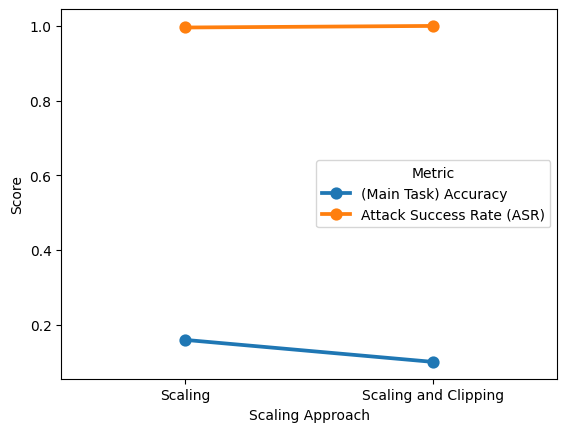

In [41]:
sns.pointplot(data=fl_scaling_df, x="Scaling Approach", y="Score", hue="Metric")

display(fl_scaling_df)

gc.collect()

A: From the results shown in the graph, I would consider the defense to be unsuccessful.
Regardless of clipping being applied as a defense, the scaling attack succeeds to insert a backdoor into the global model, although this does come at the cost of the performance of the model on the general task, as learns to only predict the backdoor's target class.
The clipping defense has not changed this fact: the ASR is practically perfect, but the accuracy is abhorrent.
However, when the logs of the aggregation rounds are inspected, one can see that some rounds end with an accuracy of almost 30%, as opposed to 10%.
This would imply that the clipping defense does have some effect, but that this effect is too weak to properly mitigate the scaling attack.